# A trivial example of 'deep ARE' with MNIST dataset
###  inspired by the [Swarbrick's blog](https://swarbrickjones.wordpress.com/2015/04/29/convolutional-autoencoders-in-pythontheanolasagne/)

## Idea
First train an autoencoder to learn a low dimension representation space for the original data. Then we can use a fully connected layer to approximate the action transform in the hidden space. Parameters  of the fully connected layer can be learned through gradient descent

Model Structure: 
![1](1.png )


In [1]:
import os, sys, urllib, gzip
sys.path.append('/home/rui/pylearn2')
from __future__ import print_function
try:
    import cPickle as pickle
except:
    import pickle
sys.setrecursionlimit(10000)

import numpy as np
from lasagne.layers import get_output, InputLayer, DenseLayer, Upscale2DLayer, ReshapeLayer
from lasagne.nonlinearities import rectify, leaky_rectify, tanh
from lasagne.updates import nesterov_momentum
from lasagne.objectives import categorical_crossentropy
import pylearn2
from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayerFast
from lasagne.regularization import regularize_layer_params, l2, l1
import theano
import theano.tensor as T
import time
import lasagne
from lasagne.layers import Conv2DLayer as Conv2DLayerSlow
from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerSlow
try:
    from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayerFast
    from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayerFast
    print('Using cuda_convnet (faster)')
except ImportError:
    from lasagne.layers import Conv2DLayer as Conv2DLayerFast
    from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerFast
    print('Using lasagne.layers (slower)')
import matplotlib
matplotlib.use('Agg') # Change matplotlib backend, in case we have no X server running..
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import Image as IPImage
from PIL import Image

Using gpu device 0: GeForce GTX 750 Ti (CNMeM is disabled, CuDNN 3007)
/home/rui/.pyenv/versions/3.5.0/envs/cae/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


Using cuda_convnet (faster)


In [2]:
f = gzip.open('/home/rui/Downloads/mnist.pkl.gz', 'rb')
try:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
except:
    train_set, valid_set, test_set = pickle.load(f)
f.close()
X, y = train_set
X = np.reshape(X, (-1, 1, 28, 28))
X_out = X.reshape((X.shape[0], -1))

In [3]:
conv_num_filters = 16
filter_size = 3
pool_size = 2
encode_size = 16
dense_mid_size = 128
pad_in = 'valid'    
pad_out = 'full'

In [4]:
def get_picture_array(X, rescale=2):
    array = X.reshape(28,28)
    array = np.clip(array, a_min = 0, a_max = 255)
    return  array.repeat(rescale, axis = 0).repeat(rescale, axis = 1).astype(np.uint8())

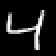

In [5]:
pic_array = get_picture_array(X[2]*255)
image = Image.fromarray(pic_array)
image.save('temp.png', format="PNG")  
IPImage('temp.png')

### define four action transforms (all four are translations)

In [6]:
def action1(X):
    array = np.zeros(X.shape,dtype = np.float32)
    array[:,:,:20,:] = X[:,:,8:28,:]
    array[:,:,20:,:] = 0
    return array
def action2(X):
    array = np.zeros(X.shape,dtype = np.float32)
    array[:,:,8:,:] = X[:,:,0:20,:]
    array[:,:,:8,:] = 0
    return array
def action3(X):
    array = np.zeros(X.shape,dtype = np.float32)
    array[:,:,:,:20] = X[:,:,:,8:28]
    array[:,:,:,20:] = 0
    return array
def action4(X):
    array = np.zeros(X.shape,dtype = np.float32)
    array[:,:,:,8:28] = X[:,:,:,:20]
    array[:,:,:,:8] = 0
    return array

### using 1000 digits image to generate the trainning set

In [7]:
data0 = X[:1000,:,:,:]
data1 = action1(data0)
data2 = action2(data0)
data3 = action3(data0)
data4 = action4(data0)

action1 is moving the digit upward

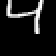

In [60]:
pic_array = get_picture_array(data1[2]*255)
image = Image.fromarray(pic_array)
image.save('temp.png', format="PNG")  
IPImage('temp.png')

In [9]:
data = np.concatenate((data0,data1,data2,data3,data4),axis = 0)
data_out = data.reshape((data.shape[0], -1))
data1_out = data1.reshape((data1.shape[0], -1))
data2_out = data2.reshape((data2.shape[0], -1))
data3_out = data3.reshape((data3.shape[0], -1))
data4_out = data4.reshape((data4.shape[0], -1))

## Structure of the network:

In [10]:
def build_cnn(input_var=None):
    
    network = InputLayer(shape=(None,  X.shape[1], X.shape[2], X.shape[3]),input_var=input_var)
    
    network = Conv2DLayerFast(network, num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh, filter_size=filter_size, pad=pad_in)

    network = Conv2DLayerFast(network, num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh, filter_size=filter_size, pad=pad_in)

    network = MaxPool2DLayerFast(network, pool_size=pool_size)

    network = Conv2DLayerFast(network, num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh, filter_size=filter_size, pad=pad_in)

    network = MaxPool2DLayerFast(network, pool_size=pool_size)
    
    network = ReshapeLayer(network, shape =(([0], -1)))
    
    network = DenseLayer(network, num_units= dense_mid_size, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh)
    
    encode_layer = DenseLayer(network, name= 'encode', num_units= encode_size, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh)
    
    action_layer = DenseLayer(encode_layer, name= 'action', num_units= encode_size, W=lasagne.init.Orthogonal(1.0),\
                            nonlinearity=lasagne.nonlinearities.tanh)
    
    network = DenseLayer(action_layer, num_units= 800, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh)
    
    network = ReshapeLayer(network, shape =(([0], 2*conv_num_filters, 5, 5)))
    
    network = Upscale2DLayer(network, scale_factor = pool_size)
    
    network = Conv2DLayerFast(network, num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh, filter_size=filter_size, pad=pad_out)

    network = Upscale2DLayer(network, scale_factor = pool_size)
    
    network = Conv2DLayerFast(network, num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh, filter_size=filter_size, pad=pad_out)

    network = Conv2DLayerSlow(network, num_filters=1, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.sigmoid, filter_size=filter_size, pad=pad_out)
    
    network = ReshapeLayer(network, shape =(([0], -1)))

    return network

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]


In [11]:
input_var = T.tensor4('inputs')
target_var = T.matrix('targets')
learnrate=0.01
# Create neural network model (depending on first command line parameter)
network = build_cnn(input_var)

with np.load('ARE_MNIST.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
lasagne.layers.set_all_param_values(network, param_values)

reconstructed = lasagne.layers.get_output(network)
loss = lasagne.objectives.squared_error(reconstructed, target_var)
loss = loss.mean()
params = lasagne.layers.get_all_params(network, trainable=True)

### first train the convolutional autoencoder using all 5000 trainning images

In [63]:
# num_epochs = 1000
# input_var = T.tensor4('inputs')
# target_var = T.matrix('targets')
# learnrate=0.01
# # Create neural network model (depending on first command line parameter)
# print("Building model and compiling functions...")
# network = build_cnn(input_var)
# reconstructed = lasagne.layers.get_output(network)
# loss = lasagne.objectives.squared_error(reconstructed, target_var)
# loss = loss.mean()
# params = lasagne.layers.get_all_params(network, trainable=True)
# updates = lasagne.updates.nesterov_momentum(
#     loss, params, learning_rate=learnrate, momentum=0.975)
# #lasagne.updates.rmsprop(loss, params, learning_rate=learnrate)
# train_fn = theano.function([input_var, target_var], loss, updates=updates,on_unused_input='warn')
# print("Starting training...")

# for epoch in range(num_epochs):
#     train_err = 0
#     train_batches = 0
#     start_time = time.time()
#     for batch in iterate_minibatches(data, data_out, 500, shuffle=False):
#         inputs, targets = batch
#         train_err += train_fn(inputs, targets)
#         train_batches += 1

#         # Then we print the results for this epoch:
#     print("Epoch {} of {} took {:.3f}s".format(
#         epoch + 1, num_epochs, time.time() - start_time))
#     print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
#     # Optionally, you could now dump the network weights to a file like this:

Building model and compiling functions...
Starting training...
Epoch 1 of 300 took 1.601s
  training loss:		0.222821
Epoch 2 of 300 took 1.538s
  training loss:		0.179169
Epoch 3 of 300 took 1.536s
  training loss:		0.126112
Epoch 4 of 300 took 1.537s
  training loss:		0.096390
Epoch 5 of 300 took 1.536s
  training loss:		0.091895
Epoch 6 of 300 took 1.537s
  training loss:		0.093381
Epoch 7 of 300 took 1.538s
  training loss:		0.094566
Epoch 8 of 300 took 1.538s
  training loss:		0.095181
Epoch 9 of 300 took 1.537s
  training loss:		0.095478
Epoch 10 of 300 took 1.537s
  training loss:		0.095600
Epoch 11 of 300 took 1.537s
  training loss:		0.095611
Epoch 12 of 300 took 1.539s
  training loss:		0.095541
Epoch 13 of 300 took 1.537s
  training loss:		0.095401
Epoch 14 of 300 took 1.536s
  training loss:		0.095194
Epoch 15 of 300 took 1.536s
  training loss:		0.094914
Epoch 16 of 300 took 1.537s
  training loss:		0.094550
Epoch 17 of 300 took 1.536s
  training loss:		0.094087
Epoch 18 of

In [76]:
# num_epochs = 1000
# updates = lasagne.updates.nesterov_momentum(
#     loss, params, learning_rate=0.005, momentum=0.975)
# # updates = lasagne.updates.rmsprop(
# #     loss, params[10:12], learning_rate=0.01)
# train_fn = theano.function([input_var, target_var], loss, updates=updates,on_unused_input='warn')
# print("Starting training...")
# best_err = 0.024
# for epoch in range(num_epochs):
#     train_err = 0
#     train_batches = 0
#     start_time = time.time()
#     for batch in iterate_minibatches(data, data_out, 500, shuffle=False):
#         inputs, targets = batch
#         train_err += train_fn(inputs, targets)
#         train_batches += 1
#         # Then we print the results for this epoch:
#     print("Epoch {} of {} took {:.3f}s".format(
#         epoch + 1, num_epochs, time.time() - start_time))
#     print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
#     if train_err / train_batches < best_err:
#         best_err = train_err / train_batches
#         np.savez('ARE_MNIST.npz', *lasagne.layers.get_all_param_values(network))


Starting training...
Epoch 1 of 1000 took 1.572s
  training loss:		0.024040
Epoch 2 of 1000 took 1.542s
  training loss:		0.024014
Epoch 3 of 1000 took 1.541s
  training loss:		0.023954
Epoch 4 of 1000 took 1.543s
  training loss:		0.023934
Epoch 5 of 1000 took 1.543s
  training loss:		0.023907
Epoch 6 of 1000 took 1.544s
  training loss:		0.023892
Epoch 7 of 1000 took 1.544s
  training loss:		0.023883
Epoch 8 of 1000 took 1.543s
  training loss:		0.023873
Epoch 9 of 1000 took 1.612s
  training loss:		0.023866
Epoch 10 of 1000 took 1.586s
  training loss:		0.023859
Epoch 11 of 1000 took 1.544s
  training loss:		0.023851
Epoch 12 of 1000 took 1.543s
  training loss:		0.023844
Epoch 13 of 1000 took 1.545s
  training loss:		0.023837
Epoch 14 of 1000 took 1.594s
  training loss:		0.023830
Epoch 15 of 1000 took 1.543s
  training loss:		0.023823
Epoch 16 of 1000 took 1.544s
  training loss:		0.023816
Epoch 17 of 1000 took 1.546s
  training loss:		0.023809
Epoch 18 of 1000 took 1.543s
  train

In [77]:
with np.load('ARE_MNIST.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
lasagne.layers.set_all_param_values(network, param_values)

In [12]:
def compare_images(X1,X2):
    image1 = Image.fromarray(get_picture_array(255 * X1))
    new_size = (image1.size[0] * 2, image1.size[1])
    new_im = Image.new('L', new_size)
    new_im.paste(image1, (0,0))
    image2 = Image.fromarray(get_picture_array(255 * X2))
    new_im.paste(image2, (image1.size[0],0))
    new_im.save('temp.png', format="PNG")
    return IPImage('temp.png')

In [13]:
output_func = theano.function([input_var], [lasagne.layers.get_output(network)])
data_pred = np.zeros((5000,784))
i = 0
for batch in iterate_minibatches(data, data_out, 1000, shuffle=False):
    inputs, targets = batch
    data_pred[1000*i:1000*(i+1),:] = output_func(inputs)[0]
    i+=1


### compare the original image with the reconstructed image 

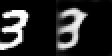

In [14]:
compare_images(data[3007],data_pred[3007])

In [15]:
all_layers = lasagne.layers.get_all_layers(network)
action_layer = all_layers[9]
action_layer.name

'action'

In [16]:
original_W = action_layer.W.get_value()
original_b = action_layer.b.get_value()

In [17]:
original_b.shape

(16,)

### generate initial weights for the four action transforms

In [18]:
action1_W = np.random.randn(original_W.shape[0],original_W.shape[1]).astype(np.float32)
action1_b = np.random.randn(original_b.shape[0]).astype(np.float32)
action2_W = np.random.randn(original_W.shape[0],original_W.shape[1]).astype(np.float32)
action2_b = np.random.randn(original_b.shape[0]).astype(np.float32)
action3_W = np.random.randn(original_W.shape[0],original_W.shape[1]).astype(np.float32)
action3_b = np.random.randn(original_b.shape[0]).astype(np.float32)
action4_W = np.random.randn(original_W.shape[0],original_W.shape[1]).astype(np.float32)
action4_b = np.random.randn(original_b.shape[0]).astype(np.float32)

### change the weights at the action layer

In [19]:
action_layer.W.set_value(action1_W)
action_layer.b.set_value(action1_b)

In [20]:
params[10:12]

[action.W, action.b]

### fix other weights, updates the action layer using the 1000 action1 trainning image

In [53]:
num_epochs = 100
# updates = lasagne.updates.nesterov_momentum(
#     loss, params[10:12], learning_rate=0.01, momentum=0.9)
updates = lasagne.updates.rmsprop(
    loss, params[10:12], learning_rate=0.001)
train_fn = theano.function([input_var, target_var], loss, updates=updates,on_unused_input='warn')
print("Starting training...")
best_err = 0.021664
for epoch in range(num_epochs):
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(data0, data1_out, 500, shuffle=False):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    if train_err / train_batches < best_err:
        best_err = train_err / train_batches
        action1_W  = action_layer.W.get_value()
        action1_b = action_layer.b.get_value()



Starting training...
Epoch 1 of 100 took 0.213s
  training loss:		0.021687
Epoch 2 of 100 took 0.199s
  training loss:		0.021666
Epoch 3 of 100 took 0.195s
  training loss:		0.021665
Epoch 4 of 100 took 0.192s
  training loss:		0.021665
Epoch 5 of 100 took 0.195s
  training loss:		0.021664
Epoch 6 of 100 took 0.192s
  training loss:		0.021664
Epoch 7 of 100 took 0.195s
  training loss:		0.021664
Epoch 8 of 100 took 0.192s
  training loss:		0.021664
Epoch 9 of 100 took 0.195s
  training loss:		0.021663
Epoch 10 of 100 took 0.192s
  training loss:		0.021663
Epoch 11 of 100 took 0.195s
  training loss:		0.021663
Epoch 12 of 100 took 0.193s
  training loss:		0.021663
Epoch 13 of 100 took 0.195s
  training loss:		0.021663
Epoch 14 of 100 took 0.192s
  training loss:		0.021663
Epoch 15 of 100 took 0.196s
  training loss:		0.021663
Epoch 16 of 100 took 0.192s
  training loss:		0.021663
Epoch 17 of 100 took 0.195s
  training loss:		0.021663
Epoch 18 of 100 took 0.192s
  training loss:		0.02166

In [26]:
np.savez('action1_weight.npz',action1_W,action1_b)

### generate test set and compare the predicted image after action transform with the ground truth image

In [29]:
test_set = X[2000:2500,:,:,:]

output_func = theano.function([input_var], [lasagne.layers.get_output(network)])
a1_pred = np.zeros((500,784))
a1_pred = output_func(test_set)[0]

In [47]:
index = np.arange(500)
np.random.shuffle(index)

In [50]:
def compare_images_array(index):
    length = len(index)
    original_image = Image.fromarray(get_picture_array(255 * test_set[index[0]]))
    width,height = original_image.size
    new_size = (width * length, height*2)
    new_im = Image.new('L', new_size)
    for i in range(length):
        a1_image = Image.fromarray(get_picture_array(255 * action1(test_set)[index[i]]))
        a1_pred_image = Image.fromarray(get_picture_array(255 * a1_pred[index[i]]))
        new_im.paste(a1_image, (i*width,0))
        new_im.paste(a1_pred_image, (i*width,height))
    new_im.save('test.png', format="PNG")
    return IPImage('test.png')

### first row is the ground truth image after action1
### second row is the predicted image given the original image

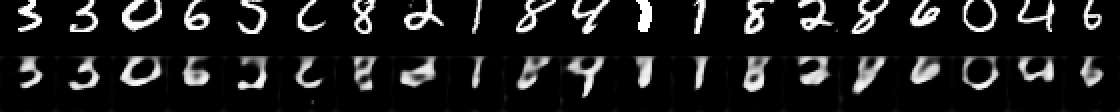

In [51]:
compare_images_array(index[:20])

## similarly we can learn other transforms at the action layer.

In [54]:
action_layer.W.set_value(action2_W)
action_layer.b.set_value(action2_b)

In [58]:
num_epochs = 1000
# updates = lasagne.updates.nesterov_momentum(
#     loss, params[10:12], learning_rate=0.01, momentum=0.9)
updates = lasagne.updates.rmsprop(
    loss, params[10:12], learning_rate=0.001)
train_fn = theano.function([input_var, target_var], loss, updates=updates,on_unused_input='warn')
print("Starting training...")
best_err = 0.025
for epoch in range(num_epochs):
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(data0, data2_out, 500, shuffle=False):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    if train_err / train_batches < best_err:
        best_err = train_err / train_batches
        action2_W  = action_layer.W.get_value()
        action2_b = action_layer.b.get_value()



Starting training...
Epoch 1 of 1000 took 0.216s
  training loss:		0.025591
Epoch 2 of 1000 took 0.197s
  training loss:		0.025418
Epoch 3 of 1000 took 0.195s
  training loss:		0.025371
Epoch 4 of 1000 took 0.192s
  training loss:		0.025354
Epoch 5 of 1000 took 0.194s
  training loss:		0.025346
Epoch 6 of 1000 took 0.192s
  training loss:		0.025341
Epoch 7 of 1000 took 0.195s
  training loss:		0.025336
Epoch 8 of 1000 took 0.192s
  training loss:		0.025332
Epoch 9 of 1000 took 0.195s
  training loss:		0.025328
Epoch 10 of 1000 took 0.192s
  training loss:		0.025324
Epoch 11 of 1000 took 0.196s
  training loss:		0.025320
Epoch 12 of 1000 took 0.218s
  training loss:		0.025316
Epoch 13 of 1000 took 0.202s
  training loss:		0.025312
Epoch 14 of 1000 took 0.195s
  training loss:		0.025309
Epoch 15 of 1000 took 0.195s
  training loss:		0.025305
Epoch 16 of 1000 took 0.192s
  training loss:		0.025301
Epoch 17 of 1000 took 0.202s
  training loss:		0.025297
Epoch 18 of 1000 took 0.224s
  train

In [59]:
np.savez('action2_weight.npz',action2_W,action2_b)

In [61]:
output_func = theano.function([input_var], [lasagne.layers.get_output(network)])
a2_pred = np.zeros((500,784))
a2_pred = output_func(test_set)[0]

In [62]:
def compare_images_array(index):
    length = len(index)
    original_image = Image.fromarray(get_picture_array(255 * test_set[index[0]]))
    width,height = original_image.size
    new_size = (width * length, height*2)
    new_im = Image.new('L', new_size)
    for i in range(length):
        a1_image = Image.fromarray(get_picture_array(255 * action2(test_set)[index[i]]))
        a1_pred_image = Image.fromarray(get_picture_array(255 * a2_pred[index[i]]))
        new_im.paste(a1_image, (i*width,0))
        new_im.paste(a1_pred_image, (i*width,height))
    new_im.save('test.png', format="PNG")
    return IPImage('test.png')

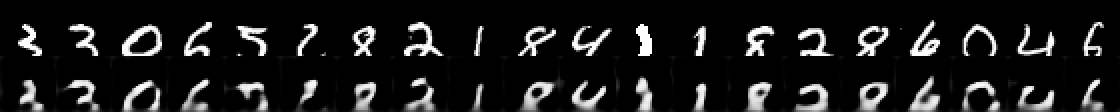

In [63]:
compare_images_array(index[:20])